In [97]:
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

In [35]:
df = pd.read_csv("data.csv")
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


<AxesSubplot:title={'center':'saatlik enerji tüketimi(MW)'}, xlabel='Datetime'>

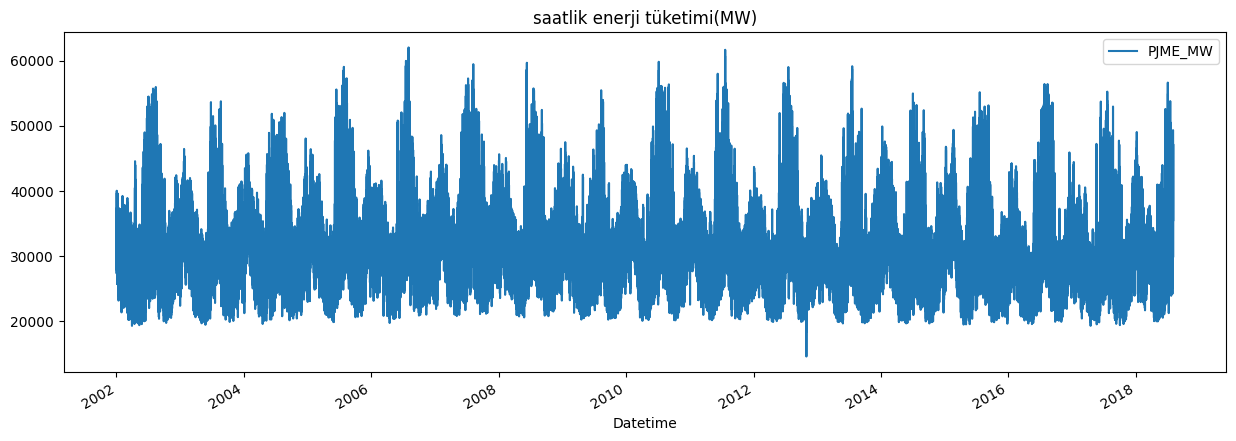

In [36]:
#normal sıralı indexi date-time çevirelim ki yıllık kullanım daha rahat görünsün.
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.plot(figsize=(15,5),title="saatlik enerji tüketimi(MW)")


In [37]:
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

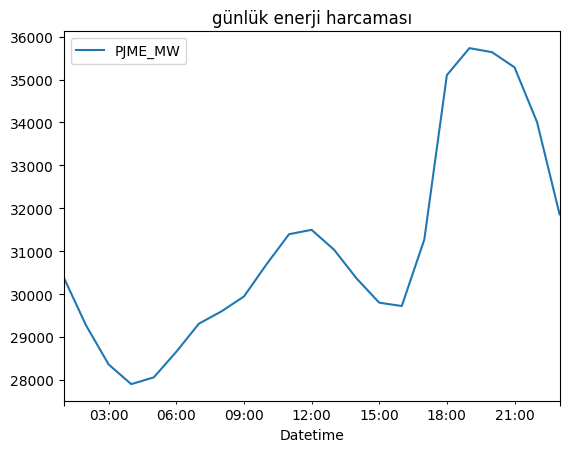

In [38]:
# GÜNLÜK:
gunluk = df.loc[ (df.index > "2002-01-01 00:00:00") & (df.index < "2002-01-02 00:00:00") ].plot(title="günlük enerji harcaması")
# göründüğü üzere biri büyük biri küçük günde 2 kere pik yapıyor.
# pikler yaklaşık öğle ve akşam 8 saatlerine denk geliyor.
# minimum kullanım gece 3-6 saatleri arasında.

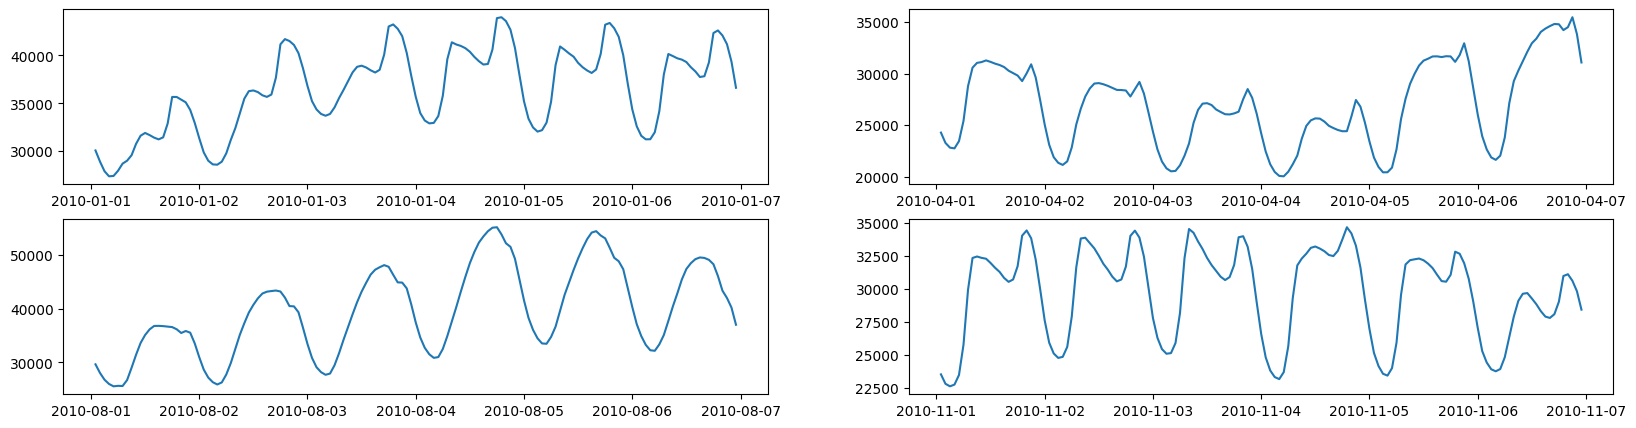

In [98]:
# HAFTALIK:
fig,axs = plt.subplots(2,2, figsize=(20,5))
haftalik1 = df.loc[ (df.index > "2010-01-01") & (df.index < "2010-01-07") ]
haftalik2 = df.loc[ (df.index > "2010-04-01") & (df.index < "2010-04-07") ]
haftalik3 = df.loc[ (df.index > "2010-08-01") & (df.index < "2010-08-07") ]
haftalik4 = df.loc[ (df.index > "2010-11-01") & (df.index < "2010-11-07") ]
haftalik1.sort_values(by='Datetime', ascending = True, inplace = True)
haftalik2.sort_values(by='Datetime', ascending = True, inplace = True)
haftalik3.sort_values(by='Datetime', ascending = True, inplace = True)
haftalik4.sort_values(by='Datetime', ascending = True, inplace = True)
axs[0,0].plot(haftalik1)
axs[0,1].plot(haftalik2)
axs[1,0].plot(haftalik3)
axs[1,1].plot(haftalik4)




#göründüğü üzere aynı yıl içinde farklı aylardaki haftalarda günlük görülen pikler arasındakı zaman ve boyut farkları değişebiliyor.


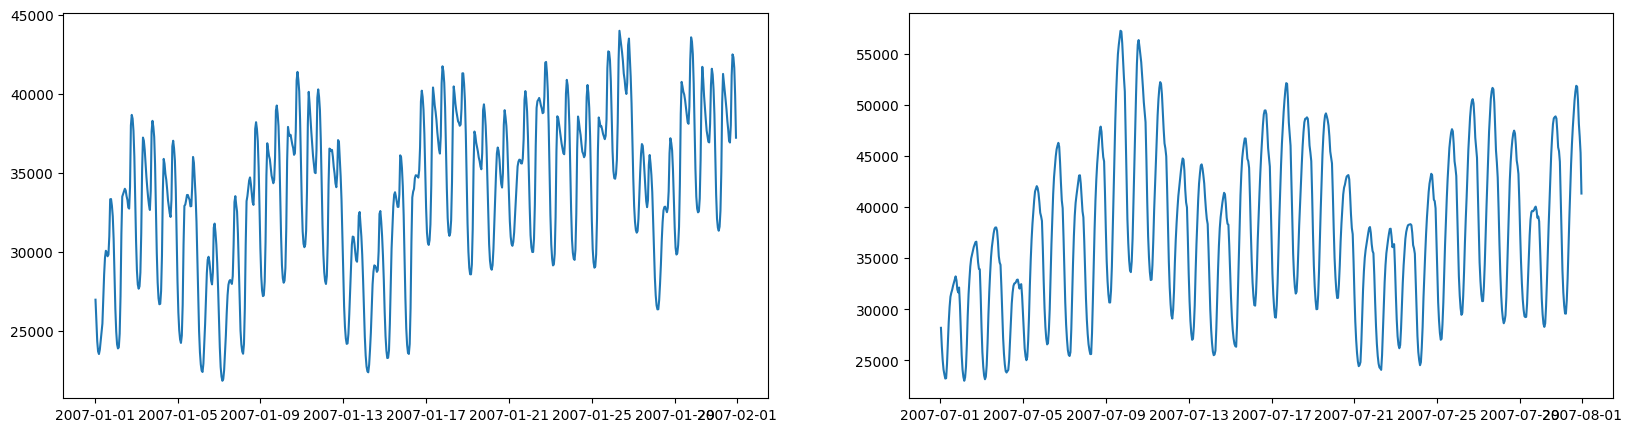

In [99]:
# AYLIK:
fig,axs = plt.subplots(1,2, figsize=(20,5))
aylik1 = df.loc[ (df.index > "2007-01-01") & (df.index < "2007-02-01") ]
aylik2 = df.loc[ (df.index > "2007-07-01") & (df.index < "2007-08-01") ]
aylik1.sort_values(by='Datetime', ascending = True, inplace = True)
aylik2.sort_values(by='Datetime', ascending = True, inplace = True)

axs[0].plot(aylik1)
axs[1].plot(aylik2)

# yaz ve kış aylarında piklerin farkları belli oluyor.
# verilerin ortalamasını alırsak ortak bir çizgiyi takip ettiğini görebiliriz.

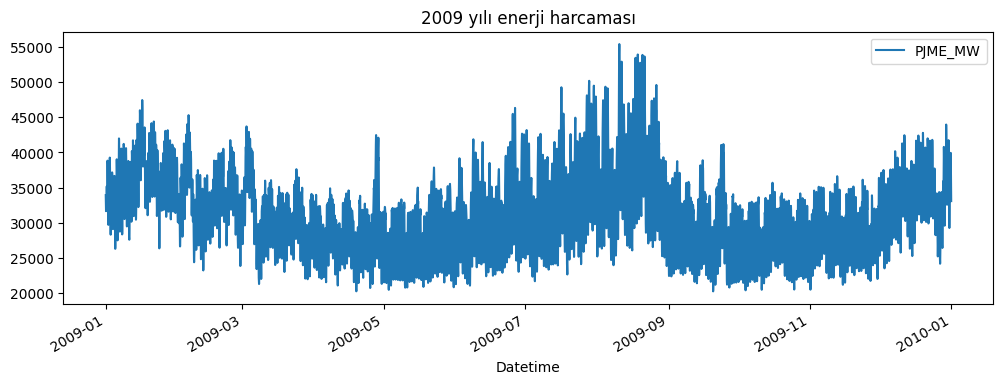

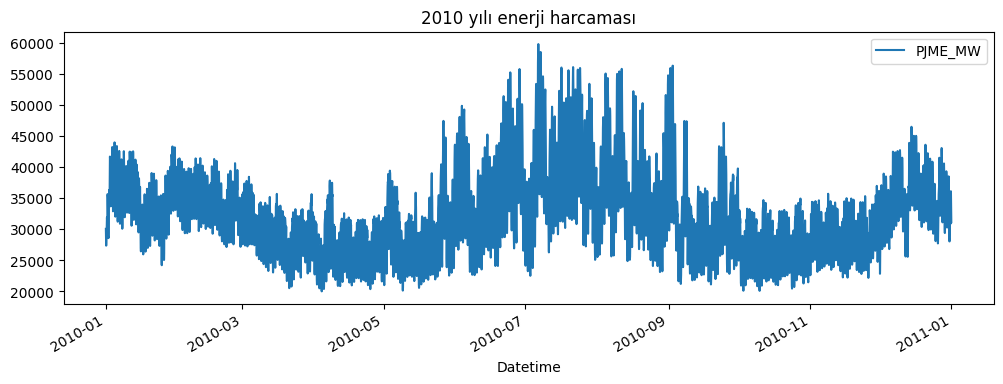

In [76]:
# SENELİK:
senelik1 = df.loc[ (df.index > "2009-01-01") & (df.index < "2010-01-01") ].plot(figsize=(12,4),title="2009 yılı enerji harcaması")
senelik1 = df.loc[ (df.index > "2010-01-01") & (df.index < "2011-01-01") ].plot(figsize=(12,4),title="2010 yılı enerji harcaması")

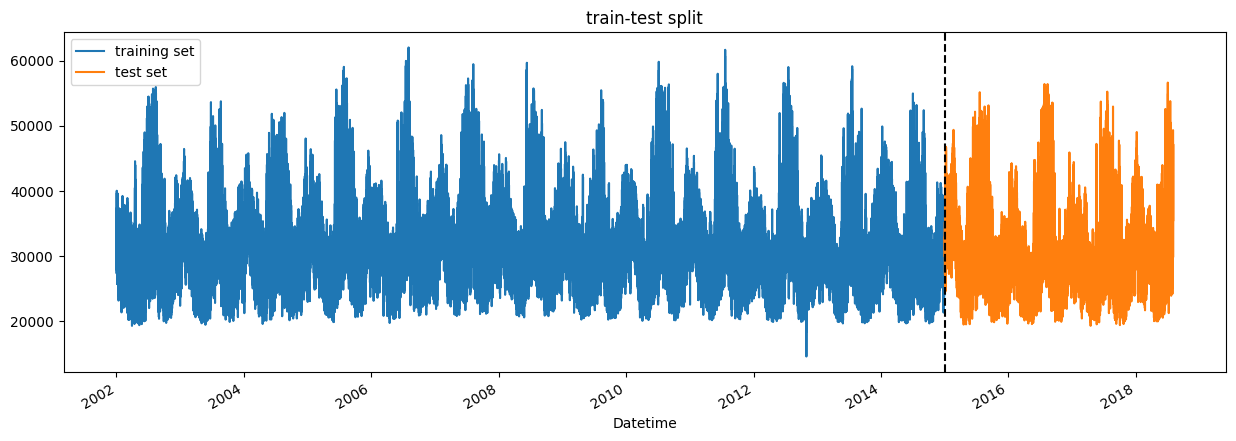

In [43]:
# train/test split:
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index >= "01-01-2015"]

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Train",title="train-test split")
test.plot(ax=ax,label="Test")
ax.axvline("01-01-2015",color="black",ls="--")
ax.legend(["training set","test set"])
plt.show()